In [ ]:
import torch
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

# 1. Genere datos de aprendizaje supervisado $Y_i = \sin(X_i) + \epsilon_i$ con $X_i \in \mathbb{R}$ y $\epsilon_i$: $\epsilon_i \overset{\text{i.i.d.}}{\sim} \text{Normal}(0, \sigma^2)$ con $\sigma$ de su elección y tamaño de muestra $n \in \{100, 1000, 5000\}$. Ajuste redes neuronales $\textit{feed-forward}$ eligiendo la profundidad y número de neuronas tales que el modelo no sobreajuste.


Epoch 1/50, Loss: 0.7826
Epoch 2/50, Loss: 0.8089
Epoch 3/50, Loss: 0.7733
Epoch 4/50, Loss: 0.6430
Epoch 5/50, Loss: 0.6085
Epoch 6/50, Loss: 0.6386
Epoch 7/50, Loss: 0.6109
Epoch 8/50, Loss: 0.5509
Epoch 9/50, Loss: 0.5364
Epoch 10/50, Loss: 0.5357
Epoch 11/50, Loss: 0.4939
Epoch 12/50, Loss: 0.4387
Epoch 13/50, Loss: 0.4143
Epoch 14/50, Loss: 0.4086
Epoch 15/50, Loss: 0.3780
Epoch 16/50, Loss: 0.3462
Epoch 17/50, Loss: 0.3434
Epoch 18/50, Loss: 0.3330
Epoch 19/50, Loss: 0.3099
Epoch 20/50, Loss: 0.3110
Epoch 21/50, Loss: 0.3137
Epoch 22/50, Loss: 0.3013
Epoch 23/50, Loss: 0.3077
Epoch 24/50, Loss: 0.3110
Epoch 25/50, Loss: 0.2995
Epoch 26/50, Loss: 0.3026
Epoch 27/50, Loss: 0.2961
Epoch 28/50, Loss: 0.2827
Epoch 29/50, Loss: 0.2819
Epoch 30/50, Loss: 0.2716
Epoch 31/50, Loss: 0.2657
Epoch 32/50, Loss: 0.2693
Epoch 33/50, Loss: 0.2661
Epoch 34/50, Loss: 0.2706
Epoch 35/50, Loss: 0.2738
Epoch 36/50, Loss: 0.2691
Epoch 37/50, Loss: 0.2686
Epoch 38/50, Loss: 0.2637
Epoch 39/50, Loss: 0.

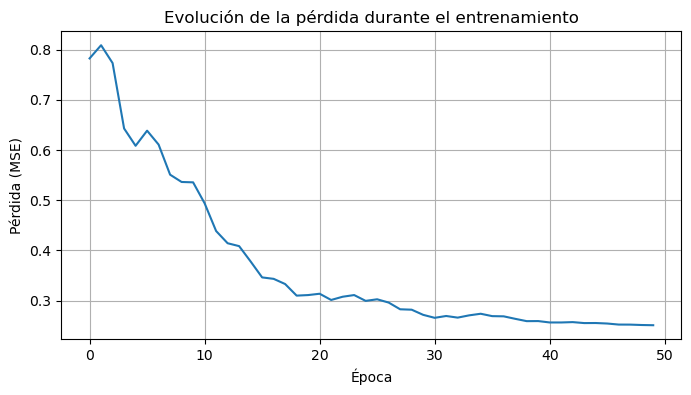

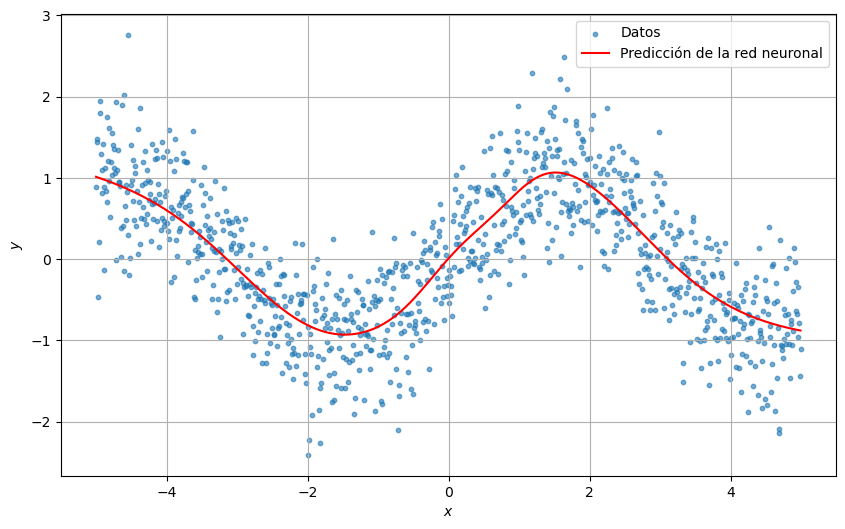

In [209]:
# Comprobar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datos generados
Norm = torch.distributions.Normal(0, 0.5)
e = Norm.sample(torch.Size([1000])).to(device)
X = torch.arange(-5, 5, 10 / 1000).unsqueeze(1).to(device)  # Mover a GPU
y = (torch.sin(X) + e.unsqueeze(1)).to(device)  # Mover a GPU

# Definir la red, el optimizador y la función de pérdida
class FFNet(torch.nn.Module):
    def __init__(self, hl_nn=10,n_inputs = 1):
        super().__init__()
        self.hl_nn = hl_nn
        self.input_layer = torch.nn.Linear(n_inputs, self.hl_nn)
        self.hidden_layer = torch.nn.Linear(self.hl_nn, 1)

    def forward(self, x):
        x = torch.tanh(self.input_layer(x))
        x = self.hidden_layer(x)
        return x

model = FFNet(hl_nn=10).to(device)  # Mover el modelo a GPU
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

# Entrenamiento
epochs = 50
losses = []

for epoch in range(epochs):
    # Forward
    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Visualización de la pérdida
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.grid()
plt.show()

# Visualización de los resultados
with torch.no_grad():
    y_pred = model(X).cpu()  # Mover las predicciones a CPU para graficar

X_cpu = X.cpu()  # Mover X a CPU para graficar
y_cpu = y.cpu()  # Mover y a CPU para graficar

plt.figure(figsize=(10, 6))
plt.scatter(X_cpu.numpy(), y_cpu.numpy(), label="Datos", alpha=0.6, s=10)
plt.plot(X_cpu.numpy(), y_pred.numpy(), color="red", label="Predicción de la red neuronal")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.grid()
plt.show()


# 2. Implemente una red neuronal cuyo input sean imágenes y evalúe el ajuste del modelo

Las imagenes que se utilizaron fueron de tumores en el cerebro, estas se pueden encontrar [aquí](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

In [2]:

# Transformación y carga de las imagenes.
data_transforms = torchvision.transforms.Compose([
torchvision.transforms.Resize((224,224)),
torchvision.transforms.RandomHorizontalFlip(),
torchvision.transforms.RandomRotation(20),
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder('imagenes/Training',
                                              transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=20,shuffle=True)


test_data = torchvision.datasets.ImageFolder('imagenes/Testing',
                                              transform=data_transforms)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=20,shuffle=False)


In [7]:

# Creación de la arquitectura de la red neuronal Convolucional
class ConvNN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.normalize1_layer = torch.nn.BatchNorm2d(3)
        # self.normalize2_layer = torch.nn.BatchNorm2d(16)
        self.normalize3_layer = torch.nn.BatchNorm2d(32)
        #self.normalize4_layer = torch.nn.BatchNorm2d(8)

        #self.Droput1_layer = torch.nn.Dropout(0.5)
        #self.Droput2_layer = torch.nn.Dropout(0.4)

        
        self.conv1_layer = torch.nn.Conv2d(3,16,kernel_size=3,padding=2)
        self.maxpo1_layer = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2_layer = torch.nn.Conv2d(16,32,kernel_size=3,padding=2)
        self.maxpo2_layer = torch.nn.MaxPool2d(kernel_size=2,stride=2)


        self.flatten_layer = torch.nn.Flatten()

        self.fc1_layer = torch.nn.Linear(103968,128)
        self.fc2_layer = torch.nn.Linear(128,4)

    def forward(self,x):

        x = self.normalize1_layer(x)
        x = self.conv1_layer(x)
        x = self.maxpo1_layer(x)
        x = torch.functional.F.relu(x)
        
        
        x = self.conv2_layer(x)
        x = self.maxpo2_layer(x)
        x = torch.functional.F.relu(x)


        x = self.normalize3_layer(x)
        x = self.flatten_layer(x)

        
        x = self.fc1_layer(x)
        x = torch.functional.F.relu(x)


        x = self.fc2_layer(x)
        x = torch.functional.F.softmax(x)
        
        

        return x

        
        
        
        

In [11]:
# Asegurarnos de tener un dispositivo adecuado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crear una instancia del modelo
model = ConvNN().to(device)

# Definir el optimizador y la función de pérdida
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Función para entrenar el modelo
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Reiniciar gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()
        
        # Estadísticas de entrenamiento por época
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


# Entrenamiento y evaluación
epochs = 20
train_model(model, train_loader, criterion, optimizer, epochs)
# evaluate_model(model, test_loader)


C:\Users\Academica\AppData\Local\Temp\ipykernel_14964\164650295.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Epoch [1/20], Loss: 1.0285, Accuracy: 71.03%
Epoch [2/20], Loss: 0.9555, Accuracy: 78.58%
Epoch [3/20], Loss: 0.9274, Accuracy: 81.32%
Epoch [4/20], Loss: 0.9288, Accuracy: 81.31%
Epoch [5/20], Loss: 0.9109, Accuracy: 83.06%
Epoch [6/20], Loss: 0.9056, Accuracy: 83.60%
Epoch [7/20], Loss: 0.9044, Accuracy: 83.65%
Epoch [8/20], Loss: 0.8910, Accuracy: 84.98%
Epoch [9/20], Loss: 0.8816, Accuracy: 86.00%
Epoch [10/20], Loss: 0.8733, Accuracy: 86.89%
Epoch [11/20], Loss: 0.8700, Accuracy: 87.22%
Epoch [12/20], Loss: 0.8656, Accuracy: 87.69%
Epoch [13/20], Loss: 0.8601, Accuracy: 88.22%
Epoch [14/20], Loss: 0.8581, Accuracy: 88.39%
Epoch [15/20], Loss: 0.8525, Accuracy: 89.03%
Epoch [16/20], Loss: 0.8497, Accuracy: 89.34%
Epoch [17/20], Loss: 0.8457, Accuracy: 89.60%
Epoch [18/20], Loss: 0.8437, Accuracy: 89.90%
Epoch [19/20], Loss: 0.8481, Accuracy: 89.36%
Epoch [20/20], Loss: 0.8402, Accuracy: 90.22%


In [12]:
# Función para evaluar el modelo en los datos de prueba
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs= model(images)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [13]:
evaluate_model(model, test_loader)

C:\Users\Academica\AppData\Local\Temp\ipykernel_14964\164650295.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.functional.F.softmax(x)


Test Accuracy: 84.59%


La Accuracy de entrenamiento fue del 90%, mientras que la Accuracy de prueba fue del 84% , esto es un buen resultado, ya que es alta y considero que no hay sobreajuste.

In [18]:
torch.save(model.state_dict(), 'modelos/brain_tumor_cnn_model.pt')

# 3 . Implemente una red neuronal para datos de serie de tiempo y evalúe el ajuste del modelo

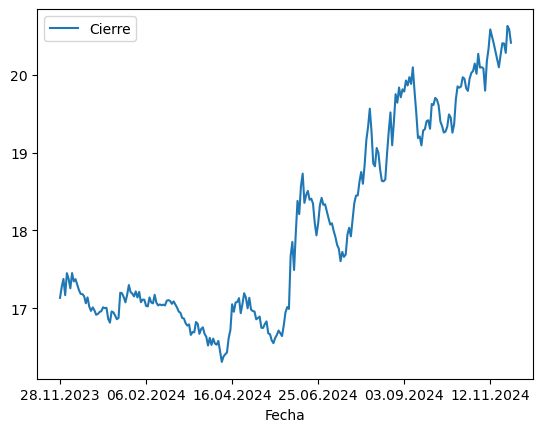

In [475]:
# Carga de los datos del tipo de cambio
usd_mxn_data = pd.read_csv('datasets/Datos históricos USD_MXN.csv',index_col=0)
X = usd_mxn_data[['Cierre']]
X[['Cierre']].plot()
plt.show()

In [476]:
# Calculo de los rendimientos.
X['Rendimientos'] = None
for i in range(len(X)-1):
    X['Rendimientos'].iloc[i+1] = (X['Cierre'].iloc[i+1]/X['Cierre'].iloc[i])-1

C:\Users\Academica\AppData\Local\Temp\ipykernel_22356\2616806716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Rendimientos'] = None
C:\Users\Academica\AppData\Local\Temp\ipykernel_22356\2616806716.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, 

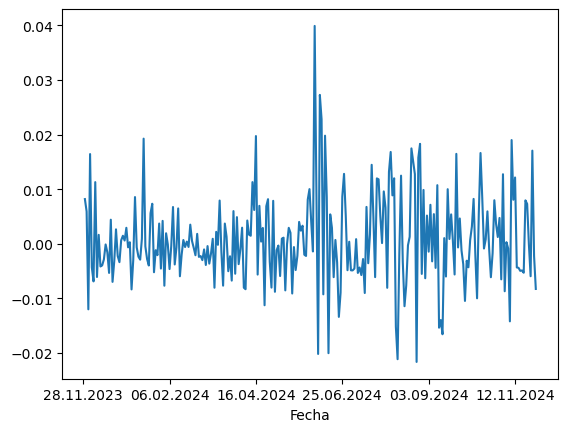

In [477]:
# Plot de los rendimientos
X['Rendimientos'].plot()
plt.show()

In [478]:
# Creación de los retrasos, los cuales serán utilizados como caracteristicas

X['r_t-1'] = X['Rendimientos'].shift()
X['r_t-2'] = X['Rendimientos'].shift(2)
X['r_t-3'] = X['Rendimientos'].shift(3)
X['r_t-4'] = X['Rendimientos'].shift(4)
X['r_t-5'] = X['Rendimientos'].shift(5)

C:\Users\Academica\AppData\Local\Temp\ipykernel_22356\1490955349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['r_t-1'] = X['Rendimientos'].shift()
C:\Users\Academica\AppData\Local\Temp\ipykernel_22356\1490955349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['r_t-2'] = X['Rendimientos'].shift(2)
C:\Users\Academica\AppData\Local\Temp\ipykernel_22356\1490955349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [479]:
X_t = X.iloc[6:,:].iloc[:,2:].values.astype('float32')
y_t = X['Rendimientos'].iloc[6:].values.astype('float32')

In [480]:
X_t = torch.Tensor(X_t)
y_t = torch.Tensor(y_t)

In [481]:
# Red Neuronal Feed Forward para predecir los rendimientos
class FFNet_TS(torch.nn.Module):
    def __init__(self, hl_nn=20,n_inputs = 1):
        super().__init__()
        self.hl_nn = hl_nn
        self.input_layer = torch.nn.Linear(n_inputs, self.hl_nn)
        self.hidden_layer = torch.nn.Linear(self.hl_nn, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = torch.functional.F.tanh(x)
        x = self.hidden_layer(x)
        return x

In [523]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_t = X_t.to(device)
y_t = y_t.to(device)

model = FFNet_TS(hl_nn=15,n_inputs=5).to(device)  # Mover el modelo a GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Entrenamiento
epochs = 80
losses = []

for epoch in range(epochs):
    # Forward
    y_pred = model(X_t)
    loss = criterion(y_pred, y_t)
    losses.append(loss.item())

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/80, Loss: 0.0400
Epoch 2/80, Loss: 0.0378
Epoch 3/80, Loss: 0.0356
Epoch 4/80, Loss: 0.0335
Epoch 5/80, Loss: 0.0315
Epoch 6/80, Loss: 0.0296
Epoch 7/80, Loss: 0.0277
Epoch 8/80, Loss: 0.0258
Epoch 9/80, Loss: 0.0241
Epoch 10/80, Loss: 0.0224
Epoch 11/80, Loss: 0.0208
Epoch 12/80, Loss: 0.0192
Epoch 13/80, Loss: 0.0177
Epoch 14/80, Loss: 0.0163
Epoch 15/80, Loss: 0.0150
Epoch 16/80, Loss: 0.0137
Epoch 17/80, Loss: 0.0125
Epoch 18/80, Loss: 0.0114
Epoch 19/80, Loss: 0.0103
Epoch 20/80, Loss: 0.0093
Epoch 21/80, Loss: 0.0083
Epoch 22/80, Loss: 0.0075
Epoch 23/80, Loss: 0.0067
Epoch 24/80, Loss: 0.0059
Epoch 25/80, Loss: 0.0052
Epoch 26/80, Loss: 0.0046
Epoch 27/80, Loss: 0.0040
Epoch 28/80, Loss: 0.0035
Epoch 29/80, Loss: 0.0030
Epoch 30/80, Loss: 0.0026
Epoch 31/80, Loss: 0.0022
Epoch 32/80, Loss: 0.0018
Epoch 33/80, Loss: 0.0015
Epoch 34/80, Loss: 0.0013
Epoch 35/80, Loss: 0.0010
Epoch 36/80, Loss: 0.0008
Epoch 37/80, Loss: 0.0007
Epoch 38/80, Loss: 0.0005
Epoch 39/80, Loss: 0.

C:\Users\Academica\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([257])) that is different to the input size (torch.Size([257, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


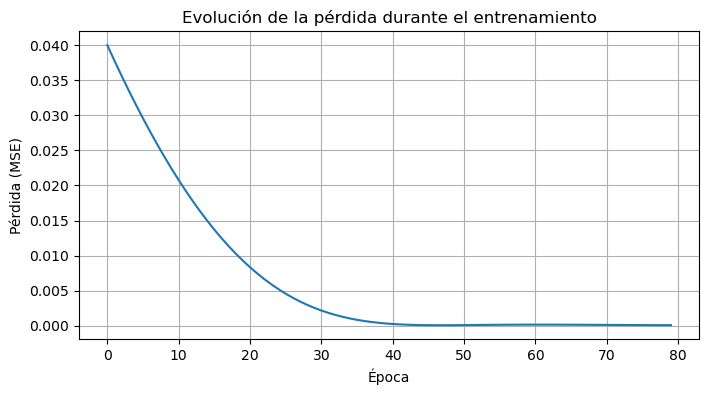

In [524]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida (MSE)")
plt.grid()
plt.show()


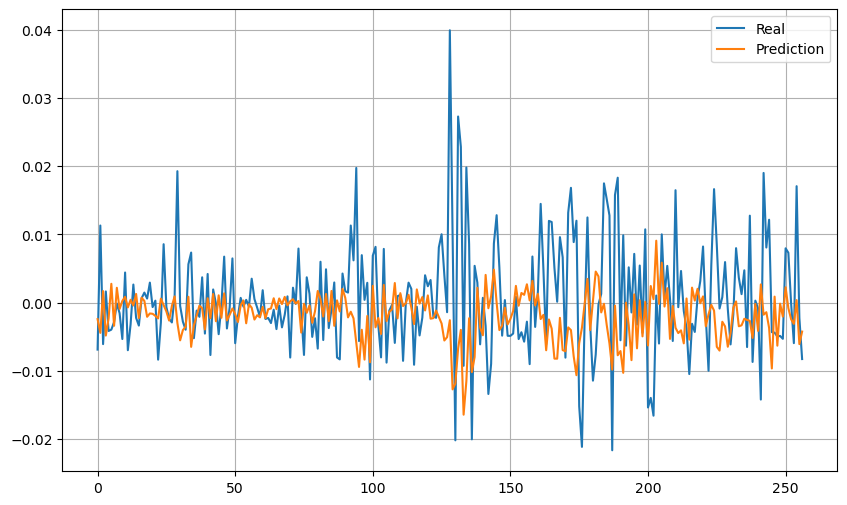

In [525]:
# Visualización de los resultados
with torch.no_grad():
    y_pred = model(X_t).cpu()  # Mover las predicciones a CPU para graficar

y_cpu = y_t.cpu()  # Mover y a CPU para graficar

plt.figure(figsize=(10, 6))
plt.plot(y_cpu,label='Real')
plt.plot(y_pred,label = 'Prediction')
plt.legend()
plt.grid()
plt.show()